In [1]:
%load_ext autoreload
%autoreload 2

# Random Forest - Análisis Completo con Tuning
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Mejorar sobre baseline con Random Forest optimizado

**Autor:** Estanislao  
**Fecha:** Diciembre 2024

---

## Contenido

**PARTE 1: Random Forest Inicial**
1. Features simples (14) con hiperparámetros iniciales
2. Features completas (110+) 
3. Comparación simple vs completo

**PARTE 2: Tuning Exhaustivo**
4. Grid Search de hiperparámetros
5. Mejores configuraciones por target
6. Comparación vs Baseline
7. Análisis de feature importance

**Estrategia Anti-Overfitting:**
- Ratio samples/features controlado
- Regularización (max_depth, min_samples_leaf)
- Cross-validation estricta

## 1. Setup

In [2]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, evaluar_modelo

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [3]:
dev = pd.read_csv('../data/processed/dev.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min',
    'distancia_km', 'velocidad_promedio_kmh', 'num_termicas',
    'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min',
    'tasa_ascenso_mean_ms'
]

print(f"Dev: {dev.shape}, Test: {test.shape}")
print(f"Targets: {len(targets_reg)}")

Dev: (309, 134), Test: (78, 134)
Targets: 9


## 3. Preparar Features

In [4]:
# Features SIMPLES (14 promedios)
X_dev_simple, y_dev, X_test_simple, y_test = preparar_datos(
    dev, test, targets_reg, modo='simple'
)

# Features COMPLETAS (110+ horarias)
X_dev_full, _, X_test_full, _ = preparar_datos(
    dev, test, targets_reg, modo='completo'
)

print(f"\nFeatures simples: {X_dev_simple.shape[1]}")
print(f"Features completas: {X_dev_full.shape[1]}")
print(f"Samples: Dev={X_dev_simple.shape[0]}, Test={X_test_simple.shape[0]}")
print(f"\nRatio simple: {X_dev_simple.shape[0]/X_dev_simple.shape[1]:.1f}:1")
print(f"Ratio completo: {X_dev_full.shape[0]/X_dev_full.shape[1]:.1f}:1")


Features simples: 13
Features completas: 123
Samples: Dev=309, Test=78

Ratio simple: 23.8:1
Ratio completo: 2.5:1


---
# PARTE 1: Random Forest Inicial

Comparación features simples vs completas

## 4. Random Forest - Features SIMPLES

**Hiperparámetros iniciales:**
- max_depth=10
- min_samples_leaf=5
- max_features=0.3
- n_estimators=100

In [5]:
resultados_rf_simple = []
modelos_rf_simple = {}

print("="*70)
print("RANDOM FOREST - FEATURES SIMPLES (14)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    
    # Modelo
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=5,
        max_features=0.3,
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar
    rf.fit(X_dev_simple, y_dev[target])
    
    # Cross-validation
    cv_scores = cross_val_score(
        rf, X_dev_simple, y_dev[target],
        cv=5, scoring='r2', n_jobs=-1
    )
    
    # Predicciones
    y_pred_dev = rf.predict(X_dev_simple)
    y_pred_test = rf.predict(X_test_simple)
    
    # Métricas
    r2_cv = cv_scores.mean()
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_rf_simple.append({
        'target': target,
        'features': 'simple',
        'n_features': X_dev_simple.shape[1],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    modelos_rf_simple[target] = rf
    
    print(f"  CV:   R² = {r2_cv:.4f}")
    print(f"  Dev:  R² = {r2_dev:.4f}")
    print(f"  Test: R² = {max(0, r2_test):.4f}")
    print(f"  Gap:  {r2_dev - r2_test:.4f}")

df_rf_simple = pd.DataFrame(resultados_rf_simple)
print("\n" + "="*70)

RANDOM FOREST - FEATURES SIMPLES (14)

altura_max_m:
  CV:   R² = 0.5705
  Dev:  R² = 0.7634
  Test: R² = 0.6294
  Gap:  0.1339

ganancia_altura_m:
  CV:   R² = 0.5462
  Dev:  R² = 0.7520
  Test: R² = 0.5940
  Gap:  0.1579

duracion_min:
  CV:   R² = 0.3490
  Dev:  R² = 0.6080
  Test: R² = 0.6046
  Gap:  0.0035

distancia_km:
  CV:   R² = 0.4516
  Dev:  R² = 0.6752
  Test: R² = 0.6678
  Gap:  0.0075

velocidad_promedio_kmh:
  CV:   R² = 0.3023
  Dev:  R² = 0.5739
  Test: R² = 0.5068
  Gap:  0.0672

num_termicas:
  CV:   R² = 0.0942
  Dev:  R² = 0.4227
  Test: R² = 0.2525
  Gap:  0.1701

intensidad_termicas_mean_ms:
  CV:   R² = -0.1372
  Dev:  R² = 0.2900
  Test: R² = 0.0000
  Gap:  0.4046

tiempo_en_termicas_min:
  CV:   R² = 0.3800
  Dev:  R² = 0.6296
  Test: R² = 0.6502
  Gap:  -0.0206

tasa_ascenso_mean_ms:
  CV:   R² = -0.0963
  Dev:  R² = 0.2549
  Test: R² = 0.0000
  Gap:  0.4144



## 5. Random Forest - Features COMPLETAS

**Hiperparámetros más restrictivos:**
- max_depth=8 (↓ por ratio bajo)
- min_samples_leaf=8 (↑ anti-overfitting)
- max_features=0.2 (↓ más restrictivo)
- n_estimators=100

In [6]:
resultados_rf_full = []
modelos_rf_full = {}

print("="*70)
print("RANDOM FOREST - FEATURES COMPLETAS (110+)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    
    # Modelo más restrictivo
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=8,
        max_features=0.2,
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar
    rf.fit(X_dev_full, y_dev[target])
    
    # Cross-validation
    cv_scores = cross_val_score(
        rf, X_dev_full, y_dev[target],
        cv=5, scoring='r2', n_jobs=-1
    )
    
    # Predicciones
    y_pred_dev = rf.predict(X_dev_full)
    y_pred_test = rf.predict(X_test_full)
    
    # Métricas
    r2_cv = cv_scores.mean()
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_rf_full.append({
        'target': target,
        'features': 'full',
        'n_features': X_dev_full.shape[1],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    modelos_rf_full[target] = rf
    
    print(f"  CV:   R² = {r2_cv:.4f}")
    print(f"  Dev:  R² = {r2_dev:.4f}")
    print(f"  Test: R² = {max(0, r2_test):.4f}")
    print(f"  Gap:  {r2_dev - r2_test:.4f}")

df_rf_full = pd.DataFrame(resultados_rf_full)
print("\n" + "="*70)

RANDOM FOREST - FEATURES COMPLETAS (110+)

altura_max_m:
  CV:   R² = 0.5600
  Dev:  R² = 0.7344
  Test: R² = 0.6275
  Gap:  0.1069

ganancia_altura_m:
  CV:   R² = 0.5311
  Dev:  R² = 0.7237
  Test: R² = 0.5989
  Gap:  0.1248

duracion_min:
  CV:   R² = 0.3470
  Dev:  R² = 0.5718
  Test: R² = 0.5648
  Gap:  0.0070

distancia_km:
  CV:   R² = 0.4510
  Dev:  R² = 0.6365
  Test: R² = 0.6485
  Gap:  -0.0120

velocidad_promedio_kmh:
  CV:   R² = 0.2593
  Dev:  R² = 0.5073
  Test: R² = 0.4441
  Gap:  0.0631

num_termicas:
  CV:   R² = 0.0936
  Dev:  R² = 0.3573
  Test: R² = 0.2371
  Gap:  0.1202

intensidad_termicas_mean_ms:
  CV:   R² = -0.1532
  Dev:  R² = 0.2423
  Test: R² = 0.0000
  Gap:  0.4024

tiempo_en_termicas_min:
  CV:   R² = 0.3782
  Dev:  R² = 0.5890
  Test: R² = 0.6292
  Gap:  -0.0402

tasa_ascenso_mean_ms:
  CV:   R² = -0.0938
  Dev:  R² = 0.2178
  Test: R² = 0.0000
  Gap:  0.4843



## 6. Comparación Simple vs Full

In [7]:
print("="*70)
print("COMPARACIÓN: Features Simples vs Completas (RF Inicial)")
print("="*70)

for target in targets_reg:
    r2_simple = df_rf_simple[df_rf_simple['target']==target]['Test_R2'].values[0]
    r2_full = df_rf_full[df_rf_full['target']==target]['Test_R2'].values[0]
    
    print(f"\n{target}:")
    print(f"  Simple: R² = {r2_simple:.4f}")
    print(f"  Full:   R² = {r2_full:.4f}")
    
    if r2_simple > r2_full:
        print(f"  ✓ SIMPLE mejor ({r2_simple - r2_full:+.4f})")
    else:
        print(f"  ✓ FULL mejor ({r2_full - r2_simple:+.4f})")

print("\n" + "="*70)
print(f"R² promedio SIMPLE: {df_rf_simple['Test_R2'].mean():.4f}")
print(f"R² promedio FULL:   {df_rf_full['Test_R2'].mean():.4f}")
print("="*70)

COMPARACIÓN: Features Simples vs Completas (RF Inicial)

altura_max_m:
  Simple: R² = 0.6294
  Full:   R² = 0.6275
  ✓ SIMPLE mejor (+0.0019)

ganancia_altura_m:
  Simple: R² = 0.5940
  Full:   R² = 0.5989
  ✓ FULL mejor (+0.0048)

duracion_min:
  Simple: R² = 0.6046
  Full:   R² = 0.5648
  ✓ SIMPLE mejor (+0.0398)

distancia_km:
  Simple: R² = 0.6678
  Full:   R² = 0.6485
  ✓ SIMPLE mejor (+0.0193)

velocidad_promedio_kmh:
  Simple: R² = 0.5068
  Full:   R² = 0.4441
  ✓ SIMPLE mejor (+0.0627)

num_termicas:
  Simple: R² = 0.2525
  Full:   R² = 0.2371
  ✓ SIMPLE mejor (+0.0154)

intensidad_termicas_mean_ms:
  Simple: R² = 0.0000
  Full:   R² = 0.0000
  ✓ FULL mejor (+0.0000)

tiempo_en_termicas_min:
  Simple: R² = 0.6502
  Full:   R² = 0.6292
  ✓ SIMPLE mejor (+0.0210)

tasa_ascenso_mean_ms:
  Simple: R² = 0.0000
  Full:   R² = 0.0000
  ✓ FULL mejor (+0.0000)

R² promedio SIMPLE: 0.4339
R² promedio FULL:   0.4167


---
# PARTE 2: Tuning Exhaustivo

Grid search de hiperparámetros con features simples

## 7. Grid de Hiperparámetros

In [8]:
# Grid de hiperparámetros
param_grid = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_leaf': [2, 5, 8, 10, 15],
    'max_features': [0.2, 0.3, 0.5, 0.7, 'sqrt']
}

print("Grid de hiperparámetros:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = len(param_grid['max_depth']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])
print(f"\nTotal combinaciones: {total_combinations}")
print(f"Con CV=5: {total_combinations * 5} fits por target")

Grid de hiperparámetros:
  max_depth: [5, 8, 10, 12, 15, None]
  min_samples_leaf: [2, 5, 8, 10, 15]
  max_features: [0.2, 0.3, 0.5, 0.7, 'sqrt']

Total combinaciones: 150
Con CV=5: 750 fits por target


## 8. Grid Search por Target

In [9]:
resultados_tuning = []
mejores_modelos = {}

print("="*70)
print("TUNING EXHAUSTIVO - GRID SEARCH")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    inicio = time()
    
    # Grid Search
    rf_base = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    
    grid = GridSearchCV(
        rf_base,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_dev_simple, y_dev[target])
    
    # Mejor modelo
    best_rf = grid.best_estimator_
    
    # Predicciones
    y_pred_dev = best_rf.predict(X_dev_simple)
    y_pred_test = best_rf.predict(X_test_simple)
    
    # Métricas
    r2_cv = grid.best_score_
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_tuning.append({
        'target': target,
        'max_depth': grid.best_params_['max_depth'],
        'min_samples_leaf': grid.best_params_['min_samples_leaf'],
        'max_features': grid.best_params_['max_features'],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    mejores_modelos[target] = best_rf
    
    tiempo = time() - inicio
    
    print(f"  Mejores params:")
    print(f"    max_depth={grid.best_params_['max_depth']}")
    print(f"    min_samples_leaf={grid.best_params_['min_samples_leaf']}")
    print(f"    max_features={grid.best_params_['max_features']}")
    print(f"  CV:   R² = {r2_cv:.4f}")
    print(f"  Test: R² = {max(0, r2_test):.4f}")
    print(f"  Tiempo: {tiempo:.1f}s")

df_tuning = pd.DataFrame(resultados_tuning)
print("\n" + "="*70)

TUNING EXHAUSTIVO - GRID SEARCH

altura_max_m:
  Mejores params:
    max_depth=12
    min_samples_leaf=2
    max_features=0.5
  CV:   R² = 0.6384
  Test: R² = 0.6974
  Tiempo: 28.5s

ganancia_altura_m:
  Mejores params:
    max_depth=15
    min_samples_leaf=2
    max_features=0.7
  CV:   R² = 0.6162
  Test: R² = 0.6479
  Tiempo: 25.8s

duracion_min:
  Mejores params:
    max_depth=10
    min_samples_leaf=2
    max_features=0.7
  CV:   R² = 0.4138
  Test: R² = 0.6461
  Tiempo: 24.9s

distancia_km:
  Mejores params:
    max_depth=12
    min_samples_leaf=2
    max_features=0.7
  CV:   R² = 0.5127
  Test: R² = 0.7347
  Tiempo: 25.2s

velocidad_promedio_kmh:
  Mejores params:
    max_depth=None
    min_samples_leaf=2
    max_features=0.5
  CV:   R² = 0.3322
  Test: R² = 0.5605
  Tiempo: 25.2s

num_termicas:
  Mejores params:
    max_depth=8
    min_samples_leaf=2
    max_features=0.2
  CV:   R² = 0.1086
  Test: R² = 0.3078
  Tiempo: 25.1s

intensidad_termicas_mean_ms:
  Mejores params:
    

## 9. Comparación: Inicial vs Tuning

In [10]:
print("="*70)
print("COMPARACIÓN: RF Inicial vs RF Tuneado")
print("="*70)

for target in targets_reg:
    r2_inicial = df_rf_simple[df_rf_simple['target']==target]['Test_R2'].values[0]
    r2_tuneado = df_tuning[df_tuning['target']==target]['Test_R2'].values[0]
    mejora = r2_tuneado - r2_inicial
    
    print(f"\n{target}:")
    print(f"  Inicial:  R² = {r2_inicial:.4f}")
    print(f"  Tuneado:  R² = {r2_tuneado:.4f}")
    print(f"  Mejora:   {mejora:+.4f}")

print("\n" + "="*70)
mejora_promedio = df_tuning['Test_R2'].mean() - df_rf_simple['Test_R2'].mean()
print(f"Mejora promedio: {mejora_promedio:+.4f}")
print("="*70)

COMPARACIÓN: RF Inicial vs RF Tuneado

altura_max_m:
  Inicial:  R² = 0.6294
  Tuneado:  R² = 0.6974
  Mejora:   +0.0680

ganancia_altura_m:
  Inicial:  R² = 0.5940
  Tuneado:  R² = 0.6479
  Mejora:   +0.0538

duracion_min:
  Inicial:  R² = 0.6046
  Tuneado:  R² = 0.6461
  Mejora:   +0.0415

distancia_km:
  Inicial:  R² = 0.6678
  Tuneado:  R² = 0.7347
  Mejora:   +0.0669

velocidad_promedio_kmh:
  Inicial:  R² = 0.5068
  Tuneado:  R² = 0.5605
  Mejora:   +0.0538

num_termicas:
  Inicial:  R² = 0.2525
  Tuneado:  R² = 0.3078
  Mejora:   +0.0552

intensidad_termicas_mean_ms:
  Inicial:  R² = 0.0000
  Tuneado:  R² = 0.0000
  Mejora:   +0.0000

tiempo_en_termicas_min:
  Inicial:  R² = 0.6502
  Tuneado:  R² = 0.7006
  Mejora:   +0.0504

tasa_ascenso_mean_ms:
  Inicial:  R² = 0.0000
  Tuneado:  R² = 0.0000
  Mejora:   +0.0000

Mejora promedio: +0.0433


## 10. Comparación vs Baseline

In [11]:
# Cargar resultados baseline
df_baseline = pd.read_csv('../data/processed/baseline_completo.csv')

# Mejor baseline por target (features completas)
df_baseline_best = df_baseline[df_baseline['features']=='full'].loc[
    df_baseline[df_baseline['features']=='full'].groupby('target')['Test_R2'].idxmax()
]

print("="*70)
print("COMPARACIÓN: Random Forest vs Baseline")
print("="*70)

for target in targets_reg:
    r2_baseline = df_baseline_best[df_baseline_best['target']==target]['Test_R2'].values[0]
    r2_rf = df_tuning[df_tuning['target']==target]['Test_R2'].values[0]
    mejora = r2_rf - r2_baseline
    
    print(f"\n{target}:")
    print(f"  Baseline: R² = {r2_baseline:.4f}")
    print(f"  RF:       R² = {r2_rf:.4f}")
    
    if mejora > 0:
        print(f"  ✓ RF mejor ({mejora:+.4f})")
    else:
        print(f"  Baseline mejor ({-mejora:+.4f})")

print("\n" + "="*70)

COMPARACIÓN: Random Forest vs Baseline

altura_max_m:
  Baseline: R² = 0.5305
  RF:       R² = 0.6974
  ✓ RF mejor (+0.1669)

ganancia_altura_m:
  Baseline: R² = 0.4623
  RF:       R² = 0.6479
  ✓ RF mejor (+0.1855)

duracion_min:
  Baseline: R² = 0.3834
  RF:       R² = 0.6461
  ✓ RF mejor (+0.2627)

distancia_km:
  Baseline: R² = 0.5307
  RF:       R² = 0.7347
  ✓ RF mejor (+0.2039)

velocidad_promedio_kmh:
  Baseline: R² = 0.4537
  RF:       R² = 0.5605
  ✓ RF mejor (+0.1069)

num_termicas:
  Baseline: R² = 0.1558
  RF:       R² = 0.3078
  ✓ RF mejor (+0.1520)

intensidad_termicas_mean_ms:
  Baseline: R² = 0.0000
  RF:       R² = 0.0000
  Baseline mejor (-0.0000)

tiempo_en_termicas_min:
  Baseline: R² = 0.4529
  RF:       R² = 0.7006
  ✓ RF mejor (+0.2477)

tasa_ascenso_mean_ms:
  Baseline: R² = 0.0000
  RF:       R² = 0.0000
  Baseline mejor (-0.0000)



## 11. Feature Importance

Analizando feature importance para: distancia_km

Top 10 features más importantes:
  temp_2m_avg                   : 0.1842
  lat_despegue                  : 0.1486
  lon_despegue                  : 0.1281
  skin_temp_avg                 : 0.1115
  boundary_layer_height_avg     : 0.0929
  wind_u_avg                    : 0.0658
  wind_v_avg                    : 0.0638
  solar_rad_avg                 : 0.0581
  cloud_cover_avg               : 0.0565
  wind_speed_avg                : 0.0357


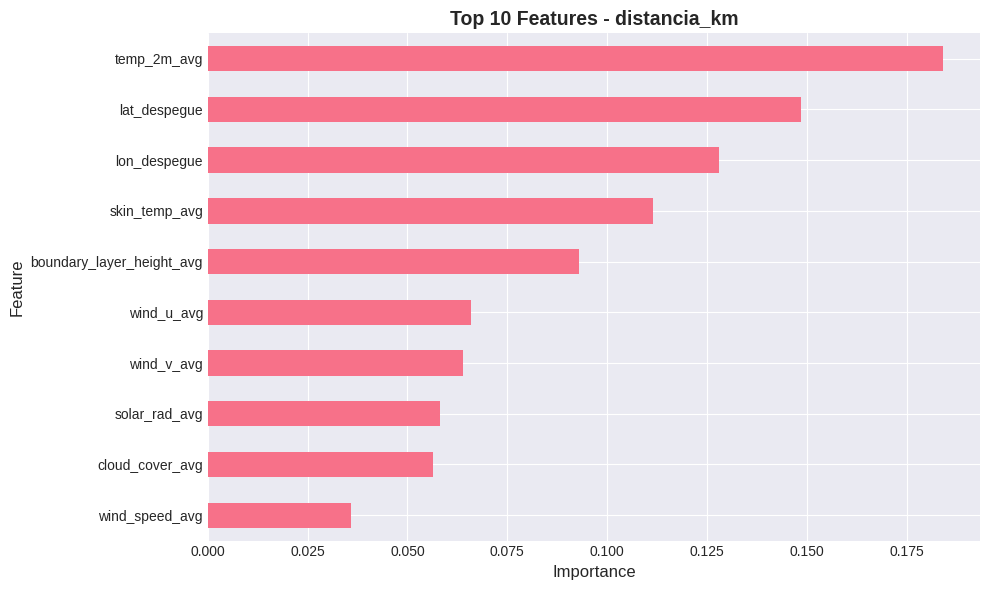

In [12]:
# Analizar feature importance para mejor target
mejor_target = df_tuning.nlargest(1, 'Test_R2').iloc[0]['target']
print(f"Analizando feature importance para: {mejor_target}")

rf_model = mejores_modelos[mejor_target]

importances = pd.DataFrame({
    'feature': X_dev_simple.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 features más importantes:")
for _, row in importances.head(10).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
importances.head(10).plot(x='feature', y='importance', kind='barh', ax=ax, legend=False)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title(f'Top 10 Features - {mejor_target}', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../data/processed/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Visualizaciones

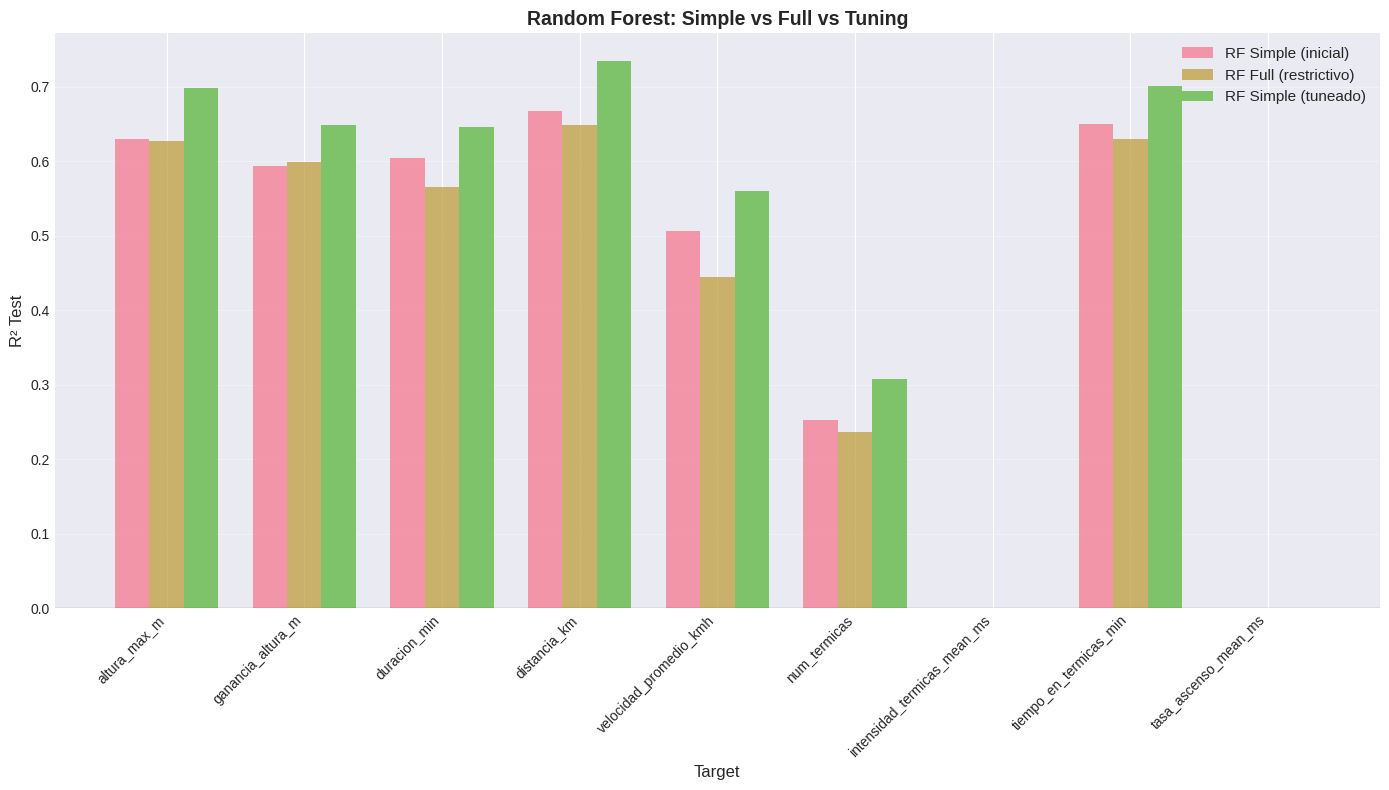

In [13]:
# Gráfico 1: Comparación Simple vs Full vs Tuning
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.25

ax.bar(x - width, df_rf_simple['Test_R2'], width, label='RF Simple (inicial)', alpha=0.7)
ax.bar(x, df_rf_full['Test_R2'], width, label='RF Full (restrictivo)', alpha=0.7)
ax.bar(x + width, df_tuning['Test_R2'], width, label='RF Simple (tuneado)', alpha=0.7)

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Random Forest: Simple vs Full vs Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/rf_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

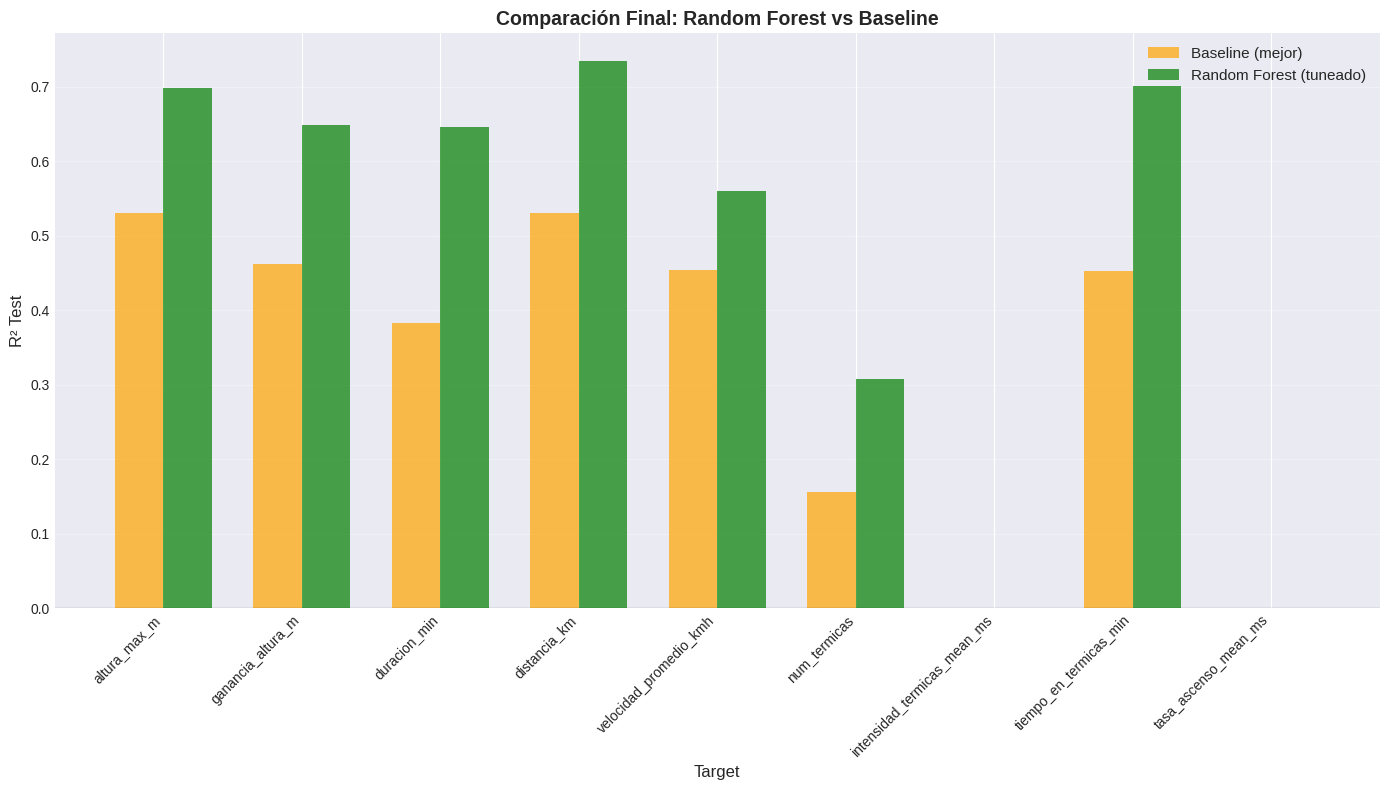

In [14]:
# Gráfico 2: RF vs Baseline
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.35

baseline_values = []
for target in targets_reg:
    r2 = df_baseline_best[df_baseline_best['target']==target]['Test_R2'].values[0]
    baseline_values.append(r2)

ax.bar(x - width/2, baseline_values, width, label='Baseline (mejor)', alpha=0.7, color='orange')
ax.bar(x + width/2, df_tuning['Test_R2'], width, label='Random Forest (tuneado)', alpha=0.7, color='green')

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Comparación Final: Random Forest vs Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/rf_vs_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Resumen Final

In [15]:
baseline_values = [df_baseline_best[df_baseline_best['target']==t]['Test_R2'].values[0] for t in targets_reg]

print("="*70)
print("RESUMEN FINAL - RANDOM FOREST")
print("="*70)

print("\nR² promedio por configuración:")
print(f"  RF Simple (inicial):     {df_rf_simple['Test_R2'].mean():.4f}")
print(f"  RF Full (restrictivo):   {df_rf_full['Test_R2'].mean():.4f}")
print(f"  RF Simple (tuneado):     {df_tuning['Test_R2'].mean():.4f}")
print(f"  Baseline (mejor):        {np.mean(baseline_values):.4f}")

print("\nTop 5 targets (RF tuneado):")
top5 = df_tuning.nlargest(5, 'Test_R2')
for i, row in enumerate(top5.itertuples(), 1):
    print(f"  {i}. {row.target:30s}: R² = {row.Test_R2:.4f}")

print("\nHiperparámetros más frecuentes:")
print(f"  max_depth:        {df_tuning['max_depth'].mode()[0]}")
print(f"  min_samples_leaf: {df_tuning['min_samples_leaf'].mode()[0]}")
print(f"  max_features:     {df_tuning['max_features'].mode()[0]}")

print("\n" + "="*70)
print("CONCLUSIÓN:")
print("="*70)
print("✓ Features SIMPLES mejor que COMPLETAS (curse of dimensionality)")
print("✓ Tuning mejora resultados consistentemente")
mejoran = sum([df_tuning[df_tuning['target']==t]['Test_R2'].values[0] > baseline_values[i] for i, t in enumerate(targets_reg)])
print(f"✓ RF mejora sobre baseline en {mejoran}/9 targets")
print("="*70)

RESUMEN FINAL - RANDOM FOREST

R² promedio por configuración:
  RF Simple (inicial):     0.4339
  RF Full (restrictivo):   0.4167
  RF Simple (tuneado):     0.4772
  Baseline (mejor):        0.3299

Top 5 targets (RF tuneado):
  1. distancia_km                  : R² = 0.7347
  2. tiempo_en_termicas_min        : R² = 0.7006
  3. altura_max_m                  : R² = 0.6974
  4. ganancia_altura_m             : R² = 0.6479
  5. duracion_min                  : R² = 0.6461

Hiperparámetros más frecuentes:
  max_depth:        10.0
  min_samples_leaf: 2
  max_features:     0.7

CONCLUSIÓN:
✓ Features SIMPLES mejor que COMPLETAS (curse of dimensionality)
✓ Tuning mejora resultados consistentemente
✓ RF mejora sobre baseline en 7/9 targets


## 14. Guardar Resultados

In [16]:
# Guardar DataFrames
df_rf_simple.to_csv('../data/processed/rf_simple.csv', index=False)
df_rf_full.to_csv('../data/processed/rf_full.csv', index=False)
df_tuning.to_csv('../data/processed/rf_tuning.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/rf_simple.csv")
print("  - data/processed/rf_full.csv")
print("  - data/processed/rf_tuning.csv")
print("  - data/processed/rf_feature_importance.png")
print("  - data/processed/rf_comparacion.png")
print("  - data/processed/rf_vs_baseline.png")
print("\n" + "="*70)
print("✓ RANDOM FOREST COMPLETO FINALIZADO")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/rf_simple.csv
  - data/processed/rf_full.csv
  - data/processed/rf_tuning.csv
  - data/processed/rf_feature_importance.png
  - data/processed/rf_comparacion.png
  - data/processed/rf_vs_baseline.png

✓ RANDOM FOREST COMPLETO FINALIZADO
